# Binary files structure
This notebook investigates the structure of the binary `raw` files. The experimental file is in the `./data` directory. The structure of the binary files is:

- events (217 bytes)
  - *detector number* - 1 byte
	- *header 0* (`fff0`) - 2 bytes
	- *header 1* - 2 bytes
	- *data length* - 2 bytes
	- *d0 ... dn* - 200 bytes
	- *time 0, 1, 2* - 6 bytes
	- *lost events* - 2 bytes
	- *checksum* - 2 bytes
Note: There probably exists some optimalization of the code below. Still searching for the right library function to use.

In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as pp

raw_file_interrupted = '/home/buben/mnt/netdata/Group-S3/Bezovka_olovo_22_02_500keV/data_2022-02-22_11_23_30_697.raw'        # defining file path
raw_file_normal = '/home/buben/mnt/netdata/Group-S3/Bezovka_olovo_22_02_750keV/data_2022-02-22_11_40_30_808.raw'

raw_file = raw_file_interrupted

In [2]:
with open(raw_file, 'rb') as f:
    hexdata = f.read().hex()    # opening the file as hex code

In [3]:
hexdata[:100]                   # showing first 100 chars

'8e7d8f7a8fbf8fd28f6f8f318ea38e238d798d038c6a8bf08b2d8ad28a5b89d1895f88e28880880987c0875486fb868f8656'

In [4]:
first_header=-1     # -1 while the index could possibly be on position 0
checkedByte=0           # the iterated variable in the cycle below
while first_header==-1:     # = while the first header not found
    if hexdata[checkedByte:checkedByte+4] == 'fff0':     # searching first header in the file
        first_header = checkedByte                      # saving the found position if lucky
    checkedByte += 1       # adding 1 to continue the search for header
print(first_header)

382


In [36]:
class Event:
    # class for parsing one event in file

    def __init__(self, data, start_byte):
        """
        Initialization. The hex data (str) and the start byte (int) needed.
        """
        self.position = start_byte      # saving the position to object for better access from outside
        self.parse_from_binary(data)    # calling the parsing function - to be clearer
    
    def parse_from_binary(self, data):

        # check header - 2 bytes
        if data[self.position:self.position+4] != 'fff0':
            print('Error: Can not create event, header not found')      # the position is probably wrong
        
        # detector code
        self.detector = int(data[self.position-2:self.position], 16)    # on byte (=> two letters) before the header
        
        # header1 - 2 bytes
        self.h1 = int(data[self.position+4:self.position+8], 16)

        # number of samples - 2 bytes
        self.length = int(data[self.position+8:self.position+12], 16)
        
        # now parse data
        self.samples = []   # preparing array
        for i in range(self.length):
            self.samples.append(int(data[4*i + self.position + 12 : 4*i + self.position + 16], 16))     # leaps over 4 letters = 2 bytes
        self.samples = np.array(self.samples)      # for better manipulation

        # times
        self.t1 = int(data[self.position + 4*self.length + 12 : self.position + 4*self.length + 16], 16)    # see the event structure
        self.t2 = int(data[self.position + 4*self.length + 16 : self.position + 4*self.length + 20], 16)    # I wasn't fixing 100 as default samples length
        self.t3 = int(data[self.position + 4*self.length + 20 : self.position + 4*self.length + 24], 16)

        # lost events & checksum
        self.lost_events = int(data[self.position + 4*self.length + 24 : self.position + 4*self.length + 28], 16)
        self.checksum = int(data[self.position + 4*self.length + 28 : self.position + 4*self.length + 32], 16)
        
        # check the next event header (the two bytes before are the detector number)
        if data[self.position + 4*self.length + 34 : self.position + 4*self.length + 38]!='fff0':
            print(f"Warning: the next event not found (instead: {data[self.position + 4*self.length + 34 : self.position + 4*self.length + 38]})")

Text(0.5, 1.0, 'Event 203580')

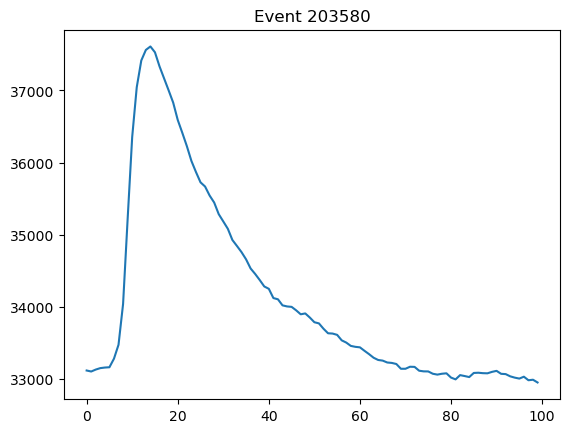

In [37]:
nth_event = 203580                       # the nth event to plot
e_n = Event(hexdata, first_header+nth_event*434-2)  # creating an instance
pp.plot(e_n.samples)                    # plotting parsed data
pp.title(f"Event {nth_event}")

Error: Can not create event, header not found


Text(0.5, 1.0, 'Event 203581')

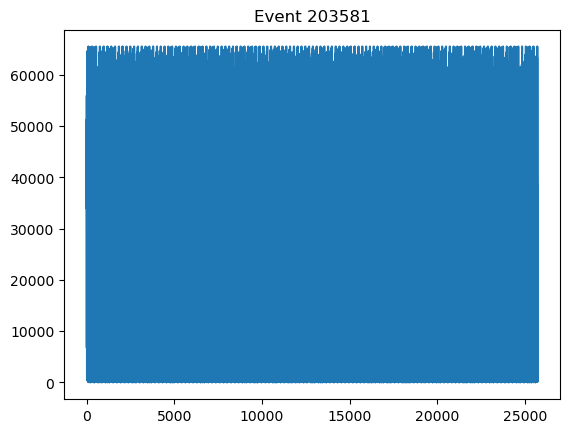

In [38]:
nth_event = 203581                       # the nth event to plot
e_n = Event(hexdata, first_header+nth_event*434-2)  # creating an instance
pp.plot(e_n.samples)                    # plotting parsed data
pp.title(f"Event {nth_event}")

In [39]:
e_n.detector

3

Error: Can not create event, header not found


Text(0.5, 1.0, 'Event 203581')

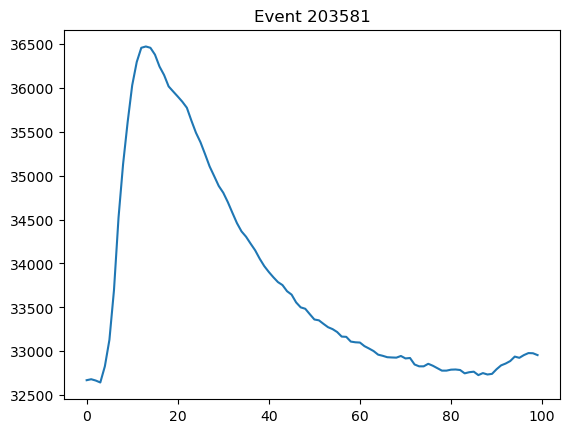

In [40]:
nth_event = 203581                       # the nth event to plot
e_n = Event(hexdata, first_header+nth_event*434-4)  # creating an instance
pp.plot(e_n.samples)                    # plotting parsed data
pp.title(f"Event {nth_event}")

In [41]:
# other values are accessible similarly:
e_n.detector

13

In [42]:
# normal event
nth_event = 203579                       # the nth event to plot
e_n = Event(hexdata, first_header+nth_event*434-2)  # creating an instance
print(e_n.detector, e_n.length, e_n.h1, e_n.samples[:3])
print(e_n.samples[-3:], e_n.t1, e_n.t2, e_n.t3, e_n.lost_events, e_n.checksum)

55 100 3855 [32309 32360 32411]
[32457 32519 32644] 31 60235 8905 0 15523


In [43]:
# interrupted event
nth_event = 203580                       # the nth event to plot
e_n = Event(hexdata, first_header+nth_event*434-2)  # creating an instance
print(e_n.detector, e_n.length, e_n.h1, e_n.samples[:3])
print(e_n.samples[-3:], e_n.t1, e_n.t2, e_n.t3, e_n.lost_events, e_n.checksum)

61 100 2575 [33118 33104 33131]
[32983 32990 32952] 31 60235 8530 0 11533


Text(0.5, 1.0, 'Event 153555')

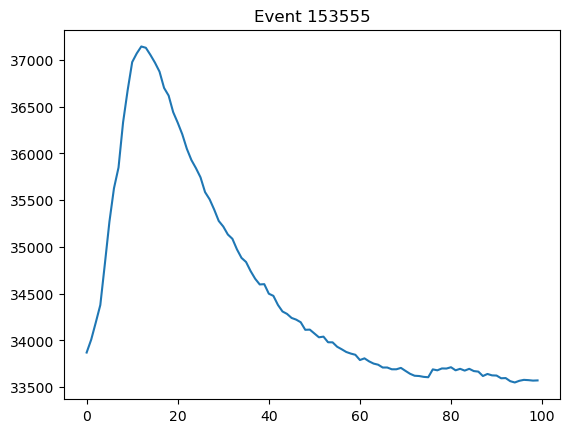

In [86]:
nth_event = 153555                       # the nth event to plot
e_n = Event(hexdata, first_header+nth_event*434)  # creating an instance
pp.plot(e_n.samples)                    # plotting parsed data
pp.title(f"Event {nth_event}")

Error: Can not create event, header not found


Text(0.5, 1.0, 'Event 153556')

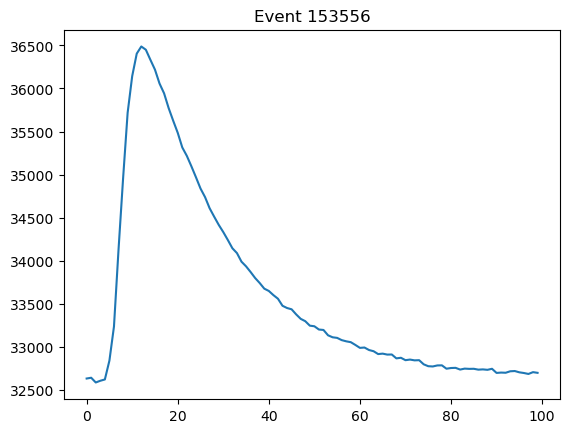

In [85]:
nth_event = 153556                       # the nth event to plot
e_n = Event(hexdata, first_header+nth_event*434-2)  # creating an instance
pp.plot(e_n.samples)                    # plotting parsed data
pp.title(f"Event {nth_event}")